**Generacion de datos iniciales**

In [305]:
# instalaciones necesarias
!pip install deap

In [306]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import numpy as np

In [307]:
# Parámetros del problema
num_parcelas = 10  # Número de parcelas
rango_caña = (100, 1200)  # Rango de cantidad de caña en kilogramos
rango_tiempo = (1.0, 10.0)  # Rango de tiempo en horas para la cosecha
rango_capacidad_vehiculos = (1000, 2500)  # Rango de capacidad de carga de los vehículos
num_vehiculos = 3  # Número de vehículos
num_trabajadores = 5  # Número de trabajadores
horas_semanales_trabajo = 40  # Horas de trabajo semanal por trabajador

In [308]:
# Generar los datos de las parcelas
parcelas = []
for i in range(1, num_parcelas + 1):
    caña = random.randint(*rango_caña)
    tiempo = round(random.uniform(*rango_tiempo), 2)
    parcelas.append({'Parcela': i, 'Caña (kg)': caña, 'Tiempo (horas)': tiempo})

In [309]:
# Generar la capacidad de los vehículos
vehiculos = [random.randint(*rango_capacidad_vehiculos) for _ in range(num_vehiculos)]

In [310]:
# Calcular la capacidad total de trabajo (en horas) de los trabajadores
capacidad_total_trabajo = num_trabajadores * horas_semanales_trabajo

In [311]:
# Crear un DataFrame con los datos de las parcelas
df_parcelas = pd.DataFrame(parcelas)

In [312]:
# Mostrar los datos generados al usuario
print(df_parcelas)

   Parcela  Caña (kg)  Tiempo (horas)
0        1       1050            4.49
1        2        869            3.12
2        3        335            6.64
3        4        831            5.63
4        5        372            7.71
5        6        319            3.82
6        7        969            2.51
7        8        329            3.83
8        9       1110            3.58
9       10       1106            7.90


In [313]:
# Crear un resumen de los vehículos y capacidad de trabajo
resumen_vehiculos = {
    'Número de vehículos': num_vehiculos,
    'Capacidad de cada vehículo (kg)': vehiculos,
    'Número de trabajadores': num_trabajadores,
    'Capacidad total de trabajo (horas)': capacidad_total_trabajo
}

resumen_vehiculos

{'Número de vehículos': 3,
 'Capacidad de cada vehículo (kg)': [1719, 1366, 2186],
 'Número de trabajadores': 5,
 'Capacidad total de trabajo (horas)': 200}

**Modelado del problema**

In [314]:
from scipy.optimize import linprog

In [315]:
# Parámetros del problema (usaremos los datos generados previamente)
cantidades_caña = df_parcelas['Caña (kg)'].values
tiempos_cosecha = df_parcelas['Tiempo (horas)'].values

In [316]:
# Variables del problema
num_parcelas = len(cantidades_caña)  # Número de parcelas
capacidad_total_trabajo = 200  # Capacidad total de trabajo (horas)
capacidad_vehiculo = min(vehiculos)  # Tomamos el vehículo con menor capacidad para la restricción más estricta

In [317]:
# Función objetivo (negativo porque linprog minimiza, y queremos maximizar)
c = -cantidades_caña  # Queremos maximizar la cantidad de caña recolectada

In [318]:
# Restricciones:
# 1. Restricción de tiempo de trabajo
A_ub = [tiempos_cosecha]
b_ub = [capacidad_total_trabajo]

# 2. Restricción de capacidad de los vehículos
A_ub.append(cantidades_caña)
b_ub.append(capacidad_vehiculo)

In [319]:
# Definir las restricciones en forma de matriz
A_ub = [tiempos_cosecha, cantidades_caña]  # Una lista con las dos restricciones
b_ub = [capacidad_total_trabajo, capacidad_vehiculo]  # Limites de tiempo y capacidad

In [320]:
# Definir los límites para las variables de decisión (0 o 1)
x_bounds = [(0, 1) for _ in range(num_parcelas)]

In [321]:
# Resolver el problema de optimización
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method='highs')

In [322]:
# Mostrar los resultados
if result.success:
    print("Resultado óptimo encontrado:")
    print("Parcelas cosechadas:", result.x)
    print("Cantidad total de caña recolectada:", -result.fun)
else:
    print("No se pudo encontrar una solución óptima.")

Resultado óptimo encontrado:
Parcelas cosechadas: [0.         0.         0.         0.         0.         0.
 0.         0.         0.23423423 1.        ]
Cantidad total de caña recolectada: 1366.0


**Algoritmo Genético (GA)**

El Algoritmo Genético (GA) está inspirado en la evolución biológica. Utiliza una población de soluciones potenciales (individuos) y las mejora a través de iteraciones aplicando operadores como selección, cruce (crossover) y mutación.

In [323]:
# la inicializacion se hizo arriba en modelado del problema

# Crear el problema de optimizacion DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Queremos maximizar la cantidad de caña
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [324]:
# Funcion de creacion de invididuos (soluciones)
def crear_individuo():
  return creator.Individual([random.randint(0,1)for _ in range(num_parcelas)])

In [325]:
# Función de aptitud (fitness) con penalización gradual
def evaluar_individuo(individuo):
    cantidad_caña_total = sum(individuo[i] * cantidades_caña[i] for i in range(num_parcelas))
    tiempo_total = sum(individuo[i] * tiempos_cosecha[i] for i in range(num_parcelas))

    penalizacion = 0  # Inicializamos la penalización en 0

    # Penalización por exceder el tiempo disponible
    if tiempo_total > capacidad_total_trabajo:
        penalizacion += (tiempo_total - capacidad_total_trabajo) * 100  # Penalización proporcional al exceso de tiempo

    # Penalización por exceder la capacidad del vehículo
    if cantidad_caña_total > capacidad_vehiculo:
        penalizacion += (cantidad_caña_total - capacidad_vehiculo) * 100  # Penalización proporcional al exceso de capacidad

    # La aptitud será la cantidad de caña recolectada menos la penalización
    return max(0, cantidad_caña_total - penalizacion),  # Asegurarse de que la aptitud no sea negativa


In [326]:
# Configuracion de los operadores geneticos
toolbox = base.Toolbox()
toolbox.register("individual", crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluar_individuo)
toolbox.register("mate",tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [327]:
# Parametros del Algoritmo Genetico
population_size = 100
num_generaciones = 50
probabilidad_cruce = 0.8
probabilidad_mutacion = 0.3

In [328]:
# seguimiento de estadisticas durante la ejecucion
stats = tools.Statistics(lambda ind: ind.fitness.values[0])  # Asegúrate de capturar el primer valor de fitness
stats.register("min", np.min)  # Registrar aptitud mínima
stats.register("avg", np.mean)  # Registrar aptitud promedio

In [329]:
# Registro para obtener valores durante la ejecución
hall_of_fame = tools.HallOfFame(1)  # Para rastrear al mejor individuo

In [330]:
# Inicializar la poblacion
poblacion = toolbox.population(n=population_size)

In [331]:
# Ejecutar el algoritmo genetico
poblacion, log = algorithms.eaSimple(poblacion, toolbox, cxpb=probabilidad_cruce, mutpb=probabilidad_mutacion, ngen=num_generaciones, stats=stats,halloffame=hall_of_fame, verbose=False)

In [332]:
# Obtener el mejor individuo de la poblacion
mejor_individuo = tools.selBest(poblacion, k=1)[0]
mejor_aptitud = evaluar_individuo(mejor_individuo)

In [333]:
# Mostrar Resultados
print("Mejor individuo", mejor_individuo)
print("Cantidad total de caña recolectada:", mejor_aptitud[0])

Mejor individuo [0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Cantidad total de caña recolectada: 1355


In [334]:
# Extraer los datos para graficar
generaciones = log.select("gen")
aptitud_minima = log.select("min")  # Obtener la aptitud mínima registrada
aptitud_promedio = log.select("avg")  # Obtener la aptitud promedio registrada

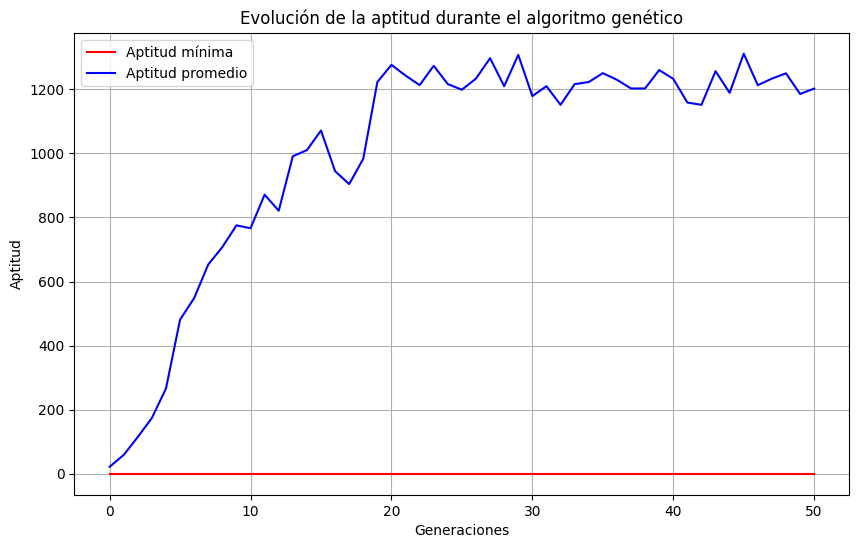

In [335]:
# Crear la grafica de la evolucion de la aptitud
plt.figure(figsize=(10, 6))
plt.plot(generaciones, aptitud_minima, label="Aptitud mínima", color="red")
plt.plot(generaciones, aptitud_promedio, label="Aptitud promedio", color="blue")
plt.xlabel("Generaciones")
plt.ylabel("Aptitud")
plt.title("Evolución de la aptitud durante el algoritmo genético")
plt.legend(loc="best")
plt.grid()
plt.show()

**Algoritmo Recocido Simulado**

El Algoritmo de Recocido Simulado (SA) está basado en el proceso físico de recocido, donde un material se calienta y luego se enfría gradualmente para minimizar su energía y alcanzar un estado óptimo. En optimización, se utiliza una estrategia similar para escapar de óptimos locales.

In [336]:
# Funcion de evaluacion
def evaluar_individuo_rc(individuo):
  cantidad_caña_total = sum(individuo[i] * cantidades_caña[i] for i in range(num_parcelas))
  tiempo_total = sum(individuo[i] * tiempos_cosecha[i] for i in range(num_parcelas))

  penalizacion = 0 # Inicializamos la penalizacion en 0

  # Penalizacion por exceder el tiempo disponible
  if tiempo_total > capacidad_total_trabajo:
    penalizacion += (tiempo_total - capacidad_total_trabajo) * 100

  # Penalizacion por exceder la capacidad del vehiculo
  if cantidad_caña_total > capacidad_vehiculo:
    penalizacion += (cantidad_caña_total - capacidad_vehiculo) * 100

  # la aptitud sera la cantidad de cana recolectada menos la penalizacion
  return max(0, cantidad_caña_total - penalizacion)


In [337]:
# Funcion para crear una solucion inicial (estado inicial)
def crear_individuo_inicial():
  return [random.randint(0,1) for _ in range(num_parcelas)]

In [338]:
# Funcion para mutar (modificar) un individuo (solucion)
def mutar_individuo(individuo):
  nuevo_individuo = individuo[:]
  idx = random.randint(0, num_parcelas - 1)
  nuevo_individuo[idx] = 1 - nuevo_individuo[idx] # Cambia de 0 a 1 o de 1 a 0
  return nuevo_individuo

In [339]:
# funcion de enfriamiento (disminuy la temperatura gradualmente)
def enfriamiento(T, alpha):
  return T * alpha

In [340]:
# Algoritno de Recocido Simulado
def recocido_simulado(temperatura_inicial, alpha, iteraciones):
  # Estado inicial
  estado_actual = crear_individuo_inicial()
  aptitud_actual = evaluar_individuo_rc(estado_actual)

  mejor_estado = estado_actual
  mejor_aptitud = aptitud_actual

  # Listas para graficar el progreso del fitness
  historico_aptitud = [aptitud_actual]

  temperatura =  temperatura_inicial

  for i in range(iteraciones):
    # Mutar el estado actual para generar un nuevo estado
    nuevo_estado = mutar_individuo(estado_actual)
    aptitud_nueva = evaluar_individuo_rc(nuevo_estado)

    # diferencia de aptitud entre el estado actual y el nuevo
    delta_aptitud = aptitud_nueva - aptitud_actual

    # Decidir si aceptamos la nueva solucion
    if delta_aptitud > 0 or random.uniform(0,1) < math.exp(delta_aptitud / temperatura):
      estado_actual = nuevo_estado
      aptitud_actual = aptitud_nueva

    # Actualizamos el mejor estado si es necesario
    if aptitud_actual > mejor_aptitud:
      mejor_estado = estado_actual
      mejor_aptitud = aptitud_actual

    # Disminuir la temperatura
    temperatura = enfriamiento(temperatura, alpha)

    # Guardar la aptitud en el historial
    historico_aptitud.append(mejor_aptitud)

  return mejor_estado, mejor_aptitud, historico_aptitud

In [341]:
# Parametros para el recocido simulado
temperatura_inicial = 1000
alpha = 0.95  # Tasa de enfriamiento
iteraciiones = 100  # Numero de iteraciones

In [342]:
# Ejecutar el algoritmo de recocido simulado
mejor_estado, mejor_aptitud, historico_aptitud = recocido_simulado(temperatura_inicial, alpha, iteraciiones)

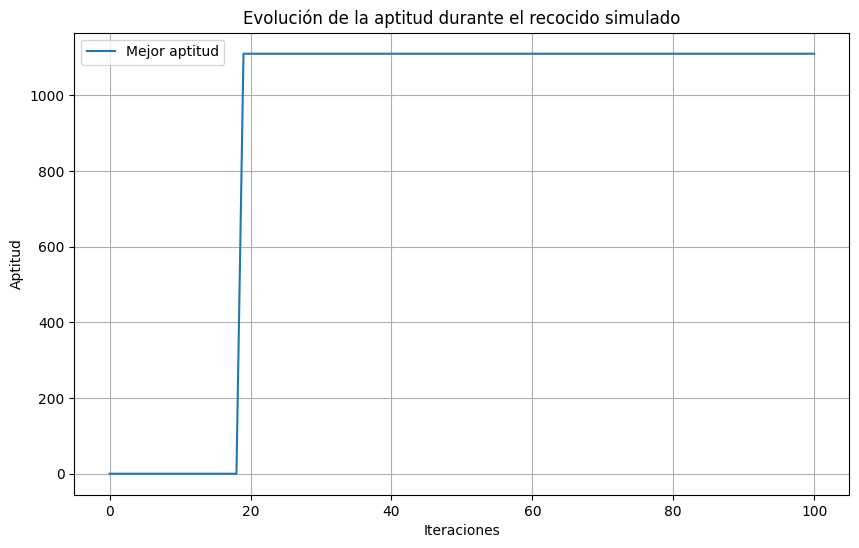

Mejor aptitud encontrada: 1110


In [343]:
# Graficar la evolucion del fitness
plt.figure(figsize=(10, 6))
plt.plot(historico_aptitud, label="Mejor aptitud")
plt.xlabel("Iteraciones")
plt.ylabel("Aptitud")
plt.title("Evolución de la aptitud durante el recocido simulado")
plt.legend(loc="best")
plt.grid()
plt.show()

print("Mejor aptitud encontrada:", mejor_aptitud)

**Algoritmo de Colonia de Hormigas (ACO)**

El ACO está inspirado en el comportamiento de las hormigas cuando buscan la mejor ruta hacia una fuente de alimento. Las hormigas dejan un rastro de feromonas, y otras hormigas tienden a seguir caminos con más feromonas, reforzando ese camino si es efectivo.

En este caso, el objetivo es maximizar la cantidad de caña recolectada respetando las restricciones, usando un enfoque donde las hormigas construyen soluciones (selección de parcelas), y los caminos buenos (parcelas seleccionadas eficientemente) reciben un refuerzo de feromonas.

In [344]:
# Parametros del ACO
num_hormigas = 50
num_iteraciones = 100
evaporacion = 0.1
influencia_feromonas = 1.0
influencia_visibilidad = 2.0
feromonas_inicial = 1.0

In [345]:
# Funcion de valuacion
def evaluar_individuo_ch(individuo):
    cantidad_caña_total = sum(individuo[i] * cantidades_caña[i] for i in range(num_parcelas))
    tiempo_total = sum(individuo[i] * tiempos_cosecha[i] for i in range(num_parcelas))

    penalizacion = 0  # Inicializamos la penalización en 0

    # Penalización por exceder el tiempo disponible, reducir penalización
    if tiempo_total > capacidad_total_trabajo:
        penalizacion += (tiempo_total - capacidad_total_trabajo) * 10  # Reducir el factor de penalización
        # print(f"Penalización por tiempo: {penalizacion}")

    # Penalización por exceder la capacidad del vehículo, reducir penalización
    if cantidad_caña_total > capacidad_vehiculo:
        penalizacion += (cantidad_caña_total - capacidad_vehiculo) * 10  # Reducir el factor de penalización
        # print(f"Penalización por capacidad: {penalizacion}")

    # La aptitud será la cantidad de caña recolectada menos la penalización
    aptitud_final = max(0, cantidad_caña_total - penalizacion)
    # print(f"Aptitud del individuo: {aptitud_final}")
    return aptitud_final

In [346]:
# Inicializacion de feromonas
feromonas = np.full((num_parcelas,), feromonas_inicial)

In [347]:
# Función para seleccionar una parcela con probabilidades basadas en las feromonas y la cantidad de caña
def seleccionar_parcela(feromonas, cantidades_caña, influencia_feromonas, influencia_visibilidad):
    probabilidades = []
    for i in range(num_parcelas):
        # Aumentamos el efecto de la visibilidad (cantidades de caña) para explorar más soluciones diversas
        prob = (feromonas[i] ** influencia_feromonas) * (cantidades_caña[i] ** influencia_visibilidad)
        probabilidades.append(prob)

    suma_probabilidades = np.sum(probabilidades)
    if suma_probabilidades == 0:
        return random.randint(0, num_parcelas - 1)  # Seleccionar aleatoriamente si todas las probabilidades son cero

    probabilidades = probabilidades / suma_probabilidades  # Normalizar las probabilidades
    return np.random.choice(range(num_parcelas), p=probabilidades)

In [348]:
# Función para construir una solución (selección de parcelas)
def construir_solucion():
    solucion = [0] * num_parcelas
    for _ in range(num_parcelas):
        parcela_seleccionada = seleccionar_parcela(feromonas, cantidades_caña, influencia_feromonas, influencia_visibilidad)
        solucion[parcela_seleccionada] = 1
    return solucion

In [349]:
# Refuerzo de feromonas en las mejores soluciones
def colonia_de_hormigas(num_hormigas, num_iteraciones, evaporacion):
    feromonas = np.full((num_parcelas,), feromonas_inicial)

    mejor_solucion = None
    mejor_aptitud = 0
    historico_aptitud = []

    for iteracion in range(num_iteraciones):
        soluciones_hormigas = []
        aptitudes_hormigas = []

        # Cada hormiga construye una solución
        for _ in range(num_hormigas):
            solucion = construir_solucion()
            aptitud = evaluar_individuo_ch(solucion)
            soluciones_hormigas.append(solucion)
            aptitudes_hormigas.append(aptitud)

        # Actualizar la mejor solución encontrada
        aptitud_max = max(aptitudes_hormigas)
        if aptitud_max > mejor_aptitud:
            mejor_aptitud = aptitud_max
            mejor_solucion = soluciones_hormigas[aptitudes_hormigas.index(aptitud_max)]

        # Evaporar feromonas
        feromonas *= (1 - evaporacion)

        # Reforzar feromonas en las mejores soluciones
        for i in range(num_parcelas):
            for solucion, aptitud in zip(soluciones_hormigas, aptitudes_hormigas):
                if solucion[i] == 1 and aptitud > 0:  # Si la parcela fue seleccionada y la solución fue buena
                    feromonas[i] += aptitud / mejor_aptitud  # Normalizamos el refuerzo de feromonas

        historico_aptitud.append(mejor_aptitud)

    return mejor_solucion, mejor_aptitud, historico_aptitud


In [350]:
# Ejecutar el algoritmo de colonia de hormigas
mejor_solucion, mejor_aptitud, historico_aptitud = colonia_de_hormigas(num_hormigas, num_iteraciones, evaporacion)

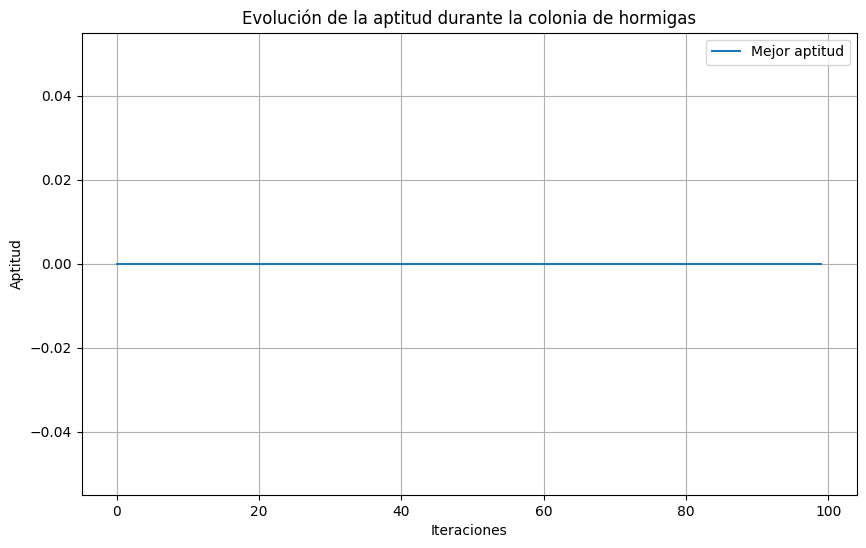

Mejor aptitud encontrada: 0


In [351]:
# Graficar la evolución del fitness
plt.figure(figsize=(10, 6))
plt.plot(historico_aptitud, label="Mejor aptitud")
plt.xlabel("Iteraciones")
plt.ylabel("Aptitud")
plt.title("Evolución de la aptitud durante la colonia de hormigas")
plt.legend(loc="best")
plt.grid()
plt.show()

print("Mejor aptitud encontrada:", mejor_aptitud)

**Verificación y Análisis de Resultados**

utilizando los tres algoritmos ya implementados: Algoritmo Genético (GA), Recocido Simulado (SA), y Colonia de Hormigas (ACO). El objetivo es comparar los algoritmos en términos de cantidad de caña recolectada (aptitud) y tiempo de ejecución.

In [352]:
import time

In [353]:
# Ejecutar y medir el tiempo del Algoritmo Genético (GA)
start_time = time.time()
poblacion, log = algorithms.eaSimple(poblacion, toolbox, cxpb=probabilidad_cruce, mutpb=probabilidad_mutacion,
                                      ngen=num_generaciones, stats=stats, halloffame=hall_of_fame, verbose=False)
mejor_individuo = tools.selBest(poblacion, k=1)[0]
mejor_aptitud_ga = evaluar_individuo(mejor_individuo)[0]
tiempo_ga = time.time() - start_time
print(f"Algoritmo Genético - Mejor aptitud: {mejor_aptitud_ga}, Tiempo de ejecución: {tiempo_ga:.4f} segundos")

Algoritmo Genético - Mejor aptitud: 1355, Tiempo de ejecución: 0.6573 segundos


In [354]:
# Ejecutar y medir el tiempo del Recocido Simulado (SA)
start_time = time.time()
mejor_estado_sa, mejor_aptitud_sa, historico_aptitud_sa = recocido_simulado(temperatura_inicial, alpha, iteraciiones)
tiempo_sa = time.time() - start_time
print(f"Recocido Simulado - Mejor aptitud: {mejor_aptitud_sa}, Tiempo de ejecución: {tiempo_sa:.4f} segundos")

Recocido Simulado - Mejor aptitud: 1203, Tiempo de ejecución: 0.0032 segundos


In [355]:
# Ejecutar y medir el tiempo del Algoritmo de Colonia de Hormigas (ACO)
start_time = time.time()
mejor_solucion_aco, mejor_aptitud_aco, historico_aptitud_aco = colonia_de_hormigas(num_hormigas, num_iteraciones, evaporacion)
tiempo_aco = time.time() - start_time
print(f"Colonia de Hormigas - Mejor aptitud: {mejor_aptitud_aco}, Tiempo de ejecución: {tiempo_aco:.4f} segundos")

Colonia de Hormigas - Mejor aptitud: 0, Tiempo de ejecución: 16.9233 segundos


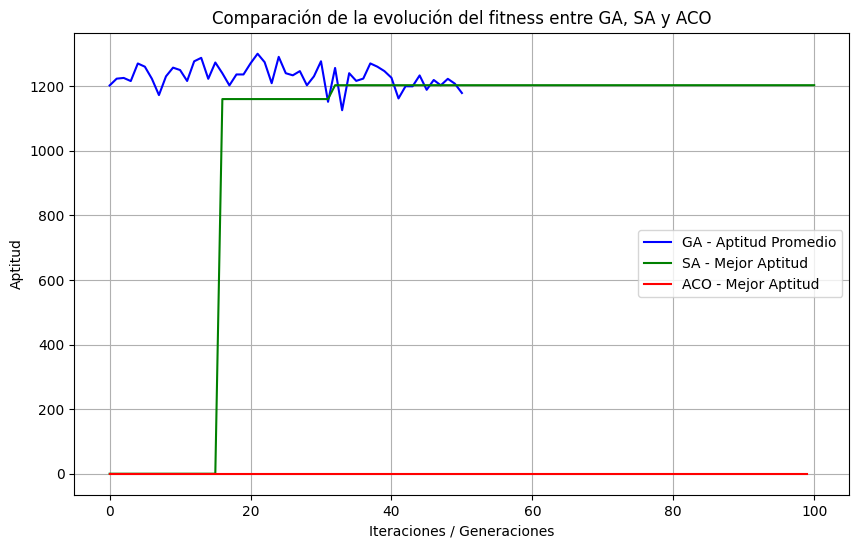

In [356]:
# Graficar la evolución del fitness para los tres algoritmos

plt.figure(figsize=(10, 6))

# Algoritmo Genético
generaciones_ga = log.select("gen")
aptitud_promedio_ga = log.select("avg")
plt.plot(generaciones_ga, aptitud_promedio_ga, label="GA - Aptitud Promedio", color="blue")

# Recocido Simulado
plt.plot(range(len(historico_aptitud_sa)), historico_aptitud_sa, label="SA - Mejor Aptitud", color="green")

# Colonia de Hormigas
plt.plot(range(len(historico_aptitud_aco)), historico_aptitud_aco, label="ACO - Mejor Aptitud", color="red")

plt.xlabel("Iteraciones / Generaciones")
plt.ylabel("Aptitud")
plt.title("Comparación de la evolución del fitness entre GA, SA y ACO")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [357]:
# Resumen comparativo
print("\nResumen Comparativo:")
print(f"Algoritmo Genético (GA): Mejor aptitud = {mejor_aptitud_ga}, Tiempo de ejecución = {tiempo_ga:.4f} segundos")
print(f"Recocido Simulado (SA): Mejor aptitud = {mejor_aptitud_sa}, Tiempo de ejecución = {tiempo_sa:.4f} segundos")
print(f"Colonia de Hormigas (ACO): Mejor aptitud = {mejor_aptitud_aco}, Tiempo de ejecución = {tiempo_aco:.4f} segundos")



Resumen Comparativo:
Algoritmo Genético (GA): Mejor aptitud = 1355, Tiempo de ejecución = 0.6573 segundos
Recocido Simulado (SA): Mejor aptitud = 1203, Tiempo de ejecución = 0.0032 segundos
Colonia de Hormigas (ACO): Mejor aptitud = 0, Tiempo de ejecución = 16.9233 segundos
